In [1]:
root_folder = '/media/DATA/jbonato/astro_segm'


In [2]:
import numpy as np
import numpy.ma as ma
import os
import h5py
from skimage import io
import matplotlib
import matplotlib.pyplot as plt 
import pandas as pd
import math
import time
import sys
import pickle
from visdom import Visdom

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from collections import defaultdict
from sklearn.metrics import f1_score
import cv2
import pandas as pd
import h5py

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

############### Visualization

from ipywidgets import Button, Layout
import ipywidgets as widgets
from ipywidgets import HBox, VBox
from IPython.display import display,clear_output,Video
from copy import copy
import numpy.ma as ma
import matplotlib.colors as colors
import imageio


sys.path.insert(0,root_folder+'/RASTA/modules/')
from gen_single_astro  import filt_im
from sel_active_reg_gen import *
from model.dense_up import dense_up

from test_fun import gen_sc_mask,fix_mask,prob_calc,small_soma_to_proc,common_merge,art_rem_large,art_rem

from get_traces import *#update_dict_DNN
from gui_results import layout
from mask_roi_from_fiji import create_mask

#model to import
model = dense_up(3)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device1 = torch.device('cpu')#('cuda:1' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


###
MAX_ROI_AREA_PROC=25
MU_PX = 1
DOMAIN_RADIUS = 45
# motion corr in extracting traces
motion_corr=True

In [3]:
#PARAMS
N=512
M=512

fov_list = [137]
fov_DNN_weights_folder = root_folder+'/weights/dense_up030_set5.pt'
set_dir=root_folder+'/set6/'

In [4]:
class SimDataset_test(Dataset):
    def __init__(self,image_set):
        self.input_images = image_set    


    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):        
        image = self.input_images[idx]
        image = torch.from_numpy(image).float()

        return image

    
vis_flag = False
##### LOAD PARAM DICT
with open(root_folder+'/set1/.tmp/dict_dataset1.txt', "rb") as fp:   #Pickling
    dict_param = pickle.load(fp)

# dict_param

In [5]:
dict_param['blocks']=8
dict_param['threads']=20
dict_param['BPM_ratio']=4

dict_param['N_pix_st']=50
dict_param['astr_min']=50

dict_param['th1_p']=.3
dict_param['th2_p']=.15

dict_param['max_min']=np.asarray([345,60])

dict_param['astro_num']=40
dict_param['bb']=80
dict_param['pad']=8
dict_param['list']=[i*54 for i in range(9)]
dict_param['list'][-1]=432

dict_param['decr_dim'] = 5
dict_param['init_th'] = 0.5

dict_param['percentile'] =70  
max_min = dict_param['max_min']
dict_param['decr_th'] = 7.333333333333333*25
dict_param

{'list': [0, 54, 108, 162, 216, 270, 324, 378, 432],
 'blocks': 8,
 'threads': 20,
 'BPM_ratio': 4,
 'bb': 80,
 'N_pix_st': 50,
 'astr_min': 50,
 'percentile': 70,
 'pad': 8,
 'astro_num': 40,
 'init_th_': 0.6,
 'decr_dim': 5,
 'decr_th': 183.33333333333331,
 'corr_int': False,
 'gpu_flag': True,
 'max_min': array([345,  60]),
 'th1_p': 0.3,
 'th2_p': 0.15,
 'init_th': 0.5}

In [6]:
def wat(pt,thresh):
    N,M = thresh.shape
    out = np.zeros((N,M,))
    mask_buff = np.zeros_like(thresh)
    mask_buff[pt]=255
    kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    mask_buff_er = cv2.erode(np.uint8(mask_buff),kernel,iterations = 3)
    ret1, labels2 = cv2.connectedComponents(mask_buff_er)
    if ret1>=3:
        # compute the exact Euclidean distance from every binary
        # pixel to the nearest zero pixel, then find peaks in this
        # distance map
        D = ndimage.distance_transform_edt(mask_buff)
        localMax = peak_local_max(D, indices=False, min_distance=5,labels=mask_buff)
        # perform a connected component analysis on the local peaks,
        # using 8-connectivity, then appy the Watershed algorithm
        markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
        labels = watershed(-D, markers, mask=mask_buff)

        print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
        A,B = np.unique(labels,return_counts=True)
        print(A,B)
        index = np.argmax(B[1:])
        print('index',A[index+1])
        # loop over the unique labels returned by the Watershed
        # algorithm
        
    
        for label in np.unique(labels):
            if label == 0:
                continue
            elif label ==A[index+1]:
                continue
            else:
                out[labels == label]=1

    return out


def small_soma_to_proc(soma_mask,N,dilation=True,watershed=True):
    mask_tot = soma_mask.copy()
    if dilation:
        kernel=cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))

        mask_tot = cv2.dilate(np.uint8(mask_tot),kernel,iterations = 1)
        kernel2=cv2.getStructuringElement(cv2.MORPH_RECT,(3,3))
        mask_tot = cv2.morphologyEx(np.uint8(mask_tot), cv2.MORPH_CLOSE, kernel)    
    
    
    mask_tot[mask_tot>0.5]=255
    mask_tot[mask_tot<=0.5]=0
    mask_tot= np.uint8(mask_tot)
    ret, labels = cv2.connectedComponents(mask_tot)
    labels = labels*soma_mask
    for i in range(1, ret+1):
        pts =  np.where(labels == i)

        if len(pts[0]) <= N:
            labels[pts] = 1
        else:
            labels[pts] = 0
            if watershed:
                labels+=wat(pts,soma_mask)   
                
    mask_tot=labels
    return mask_tot

In [7]:
dict_im = {}
dict_im['Astro_domain_radius'] = DOMAIN_RADIUS
for jj in fov_list:
    print(jj)
    #im_list = []
    Res_1 = np.zeros((N,M,3))

    test_folder_str =str(jj)
    if len(test_folder_str)==1:
        test_folder_str1=test_folder_str
    else:
        test_folder_str1='0'+test_folder_str

    model.load_state_dict(torch.load(fov_DNN_weights_folder))
    
    #collect stack to analyze
    stack_dir = set_dir+test_folder_str1+'/'

    items_stack = os.listdir(stack_dir)

    print(stack_dir + items_stack[0])
    stack = io.imread(stack_dir + items_stack[0]).astype(np.uint16)
    #stack = io.imread('/media/DATA/jbonato/motion_corrected/0137/TSeries-11182021-1331-1342_Ch2__movie_corrected_aligned.tiff').astype(np.uint16)
    dict_im['t-series_'+test_folder_str1] = stack
    frames,_,_ = stack.shape


    a_reg = sel_active_reg(stack.astype(np.float32),dict_param)
    #A,B = a_reg.sel_active_reg_gpu_gen()
    
    mask = a_reg.get_mask(long_rec=True)
#     mask = fix_mask(mask) rem for small pixel size
    
    #im_list.append([mask,'Active Regions'])
    dict_im['Active Regions_'+test_folder_str1] = mask
    
    filter_ = filt_im(stack,mask,dict_param['bb']-8)
    _, image_to_plot = filter_.create_img_d4_par()
    
    # for other dataset spatia_pp methods can be called from filter_, outputs are stack filtered and spatial map enhanced  
    #im_list.append([image_to_plot,'Enhanced'])
    dict_im['Enhanced_'+test_folder_str1] = image_to_plot
    coord_l = filter_.get_instances()
    
    assert coord_l!=0, 'Check Active region extraction module'
    
    
    image_stack = np.empty((len(coord_l),dict_param['bb'],dict_param['bb'])) 

    image_stack,filt_imageL = filter_.save_im_par(pad=4,im_enh=image_to_plot)#select the padding val 5 is default#dict_param['pad']
    
    
    image_set = image_stack[:,0,:,:]
    image_set = image_set[:,np.newaxis,:,:]

    imageL_set = image_to_plot*filt_imageL
    test_im = imageL_set.copy()
    imageL_set-=np.mean(imageL_set)
    imageL_set= imageL_set[np.newaxis,np.newaxis,:,:]



    model.eval()   # Set model to evaluate mode
#     ######################################## Prob Map
    test_datasetL = SimDataset_test(imageL_set)
    test_loader = DataLoader(test_datasetL, batch_size=15, shuffle=False, num_workers=0)

    inputs = next(iter(test_loader))
    inputs = inputs.to(device)
    pred = model(inputs)
    
    pred_mean = pred.data.cpu().numpy()
    del test_datasetL,test_loader, inputs,pred
    
    mean = pred_mean[0]
    maxim = np.amax(mean,axis=0)
    mean[mean<maxim]=0
        
    prob_mapPL,sm_ent = prob_calc(mean[1,:,:],max_min[0],max_min[1])
    
    #im_list.append([prob_mapPL,'Prob. Map'])
    dict_im['Prob. Map PL_'+test_folder_str1] = prob_mapPL
    #im_list.append([sm_ent,'Prob. Map'])
    dict_im['Prob. Map_'+test_folder_str1] = sm_ent
#     ########################################## putative single cell
    test_dataset_S = SimDataset_test(image_set)
    test_loader = DataLoader(test_dataset_S, batch_size=15, shuffle=False, num_workers=0)

    
    pred_mean=[]
    for inputs in test_loader:
        inputs = inputs.to(device)

        pred = model(inputs)
        pred_mean.append(pred.data.cpu().numpy())
        del inputs,pred

    torch.cuda.empty_cache()
    
    for j in range(1,len(pred_mean)):
        pred_mean[0]=np.vstack((pred_mean[0],pred_mean[j]))

    prob_map = np.zeros((N,M,2))

    for i in range(len(coord_l)):
        mean= np.zeros((3,dict_param['bb'],dict_param['bb']))
        mean = pred_mean[0][i,:,:,:].copy()
        
        maxim = np.amax(mean,axis=0)
        mean[mean<maxim]=0
        mean[mean>=maxim]=1

        small_soma = small_soma_to_proc(mean[1,:,:],N = int((2/3)*max_min[1])) ####remove too small somata segmentated
        mean[0,:,:]+=small_soma
        mean[1,:,:]-=small_soma
        
        coord = coord_l[i]
        dict_param['pad']=4
        if dict_param['pad']>0:
            Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
            Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,dict_param['pad']:-dict_param['pad'],dict_param['pad']:-dict_param['pad']]
        else:
            Res_1[coord[1]:coord[3],coord[0]:coord[2],0] += mean[0,:,:]
            Res_1[coord[1]:coord[3],coord[0]:coord[2],1] += mean[1,:,:]


    Res_1[:,:,0] -= Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

#     ######### can be wrapped
    
    soma_f = common_merge(Res_1[:,:,1],sm_ent)
    Res_1[:,:,1]=soma_f

    #remove possible artifacts
    small_soma = small_soma_to_proc(Res_1[:,:,1],int(0.9*max_min[1]),dilation=False)
    Res_1[:,:,1]-=small_soma

    Res_1[:,:,0] = Res_1[:,:,0]-Res_1[:,:,1]
    Res_1[Res_1<1]=0
    Res_1[Res_1>0]=1

    #remove large region classified as soma Area>500
#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=int(1.15*max_min[0]))
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]

#     Res_1_filt,removal = art_rem_large(Res_1[:,:,1],Res_1[:,:,0],N=max_min[0])
#     if removal<2:
#         Res_1-=Res_1_filt[:,:,np.newaxis]


    #remove processes without soma
    Res_1_filt = art_rem(Res_1[:,:,1],Res_1[:,:,0])
    Res_1*=Res_1_filt[:,:,np.newaxis]
    

#     with h5py.File('/media/DATA/jbonato/astro_segm/Results/D5/FOV_'+test_folder_str1+'.hdf5','w') as f:
#         dset = f.create_dataset('Values',data=Res_1[:,:,0])
#         dset2 = f.create_dataset('Values_soma',data=Res_1[:,:,1])
    
# #     dict_im['Final_Mask_'+test_folder_str1] = Res_1
# #     print(20*'%')
# #     #######################################################################################################
# #     #Visualization of images
# #     if vis_flag:
# #         vis = Visdom(port=8097, server="http://localhost",env='inference_plot')
# #         for key in dict_im.keys():
# #             if key in ['Active Regions_'+test_folder_str1,'Enhanced_'+test_folder_str1,'Final_Mask_'+test_folder_str1]:
# #                 image = dict_im[key]
# #                 fig, ax = plt.subplots(figsize=(4,4))
# #                 ax.imshow(image)
# #                 ax.axis('off')
# #                 ax.set_title(key)
# #                 vis.matplot(fig)
# #                 plt.close(fig)
    
# #     #### Extraction
    


137
/media/DATA/jbonato/astro_segm/set6/0137/TSeries-11182021-1331-1340_Ch2__movie_corrected_aligned.tiff
GEN
Computing local thresholds
Iteration per block:  4.5
GPU started with  (8, 8)  blocks and  (20, 20)  threads per block
0
1
2
3
4
5
6
7
8
9
GPU done
Init threshold 5400.0
Zones 48
file already loaded


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 760 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1210 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1760 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 2410 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 3160 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 4010 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 4960 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 6010 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 7160 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 8410 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 9000 out of 9000 | elapsed:    7.3s finished


10.034692287445068


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:   39.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  47 out of  47 | elapsed:   11.4s finished


[INFO] 3 unique segments found
[0 1 2 3] [261882     53    149     60]
index 2
[INFO] 3 unique segments found
[0 1 2 3] [262065     34     13     32]
index 1


In [8]:
dict_im['Final_Mask_'+test_folder_str1] = Res_1
single_astro_roi = gen_sc_mask(dict_im['Final_Mask_'+test_folder_str1])
dict_im = update_dict_DNN(dict_im,single_astro_roi,test_folder_str1,True,MAX_ROI_AREA_PROC,MU_PX)
#### save dict
del dict_im['t-series_'+test_folder_str1]
pickle.dump(dict_im, open( "inference_ex.pkl", "wb" ) )

Split CComp
ROI NUM 24
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 1
SPLIT DONE (1, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (1, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 2
SPLIT DONE (2, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 1
SPLIT DONE (1, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 1
SPLIT DONE (1, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 5
ROIS 1
SPLIT DONE (1, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 6
ROIS 8
SPLIT DONE (8, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 7
ROIS 4
SPLIT DONE (4, 512, 512)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%

In [9]:
dict_im.keys()

dict_keys(['Astro_domain_radius', 'Active Regions_0137', 'Enhanced_0137', 'Prob. Map PL_0137', 'Prob. Map_0137', 'Final_Mask_0137', 'Single_cell_mask_0137', 'Cell_num_0137', 'Signals_extr_0137', 'ROI_0137', 'crop_coord_ROI_0137', 'shift_ROI_0137', 'Final_Mask_fraction_0137'])

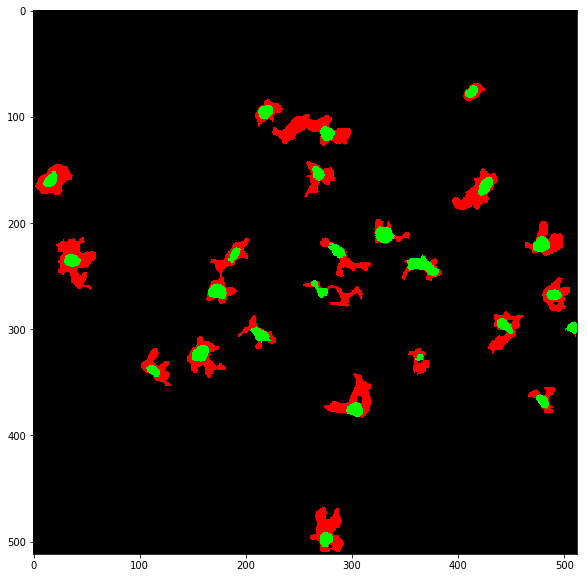

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(Res_1)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image_to_plot)

In [11]:
def gen_raw_dataframe(single_astro_roi,stack_list_path,motion_corr,MAX_ROI_AREA_PROC,MU_PX,Astro_radius,MiniROI=False,gpu=True):
    
    print("ROI NUM",single_astro_roi.shape[0])    
    
    dict_im = {}
    dataframe_list = []
    
    if motion_corr : mc  = Motion_Correction(pix_precision=1,gpu=gpu)
    fov_num = 0 
    for stack_path in stack_list_path:
        
        print('Analyzing: ',stack_path)
        stack_current = io.imread(stack_path)
        
        dict_roi={}
        dict_traces={}
        dict_cell_coord={}
        dict_cell_shift={}
        
        for s_roi_num in range(single_astro_roi.shape[0]):
            name = str(s_roi_num)

            coord_list_st,coord_list_circle, coord_list_cell = create_bb_coord_domain(single_astro_roi[s_roi_num,:,:,1])
            dict_cell_coord['ST_'+f'{name:0>3}'] = coord_list_st[0]
            dict_cell_coord['CIRCLE_'+f'{name:0>3}'] = coord_list_circle[0]
            dict_cell_coord['BB_cell_'+f'{name:0>3}'] = coord_list_cell[0]
            if motion_corr:
                coord_bb = coord_list_cell[0]
    #             print('Shift_'+f'{name:0>3}')
                dict_cell_shift['Shift_'+f'{name:0>3}'] = mc.motion_corr(stack_current[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]],\
                               ref_image=np.mean(stack_current[:,coord_bb[1]:coord_bb[3],coord_bb[0]:coord_bb[2]],axis=0))

                stack_buffer = allineate_stack(stack_current,dict_cell_shift['Shift_'+f'{name:0>3}'],r_domain=Astro_radius)
            else:
                stack_buffer = stack_current

            print(50*'%','Extracting cell:',s_roi_num)
            constr_split_roi = Extr_miniROI(MAX_ROI_AREA_PROC,MU_PX,single_astro_roi[s_roi_num,:,:,0],single_astro_roi[s_roi_num,:,:,1],MiniROI,2)
            arr_out_proc = constr_split_roi.get_miniROI()
            if  s_roi_num==0:
                list_out=arr_out_proc
            else:
                list_out = np.dstack((list_out,arr_out_proc))

            dict_roi['Soma_'+f'{name:0>3}'] = np.where(single_astro_roi[s_roi_num,:,:,1]==1)
            dict_traces['Soma_'+f'{name:0>3}'] = get_signal(single_astro_roi[s_roi_num,:,:,1],stack_buffer)
            for proc_num in range(arr_out_proc.shape[2]):
                name_proc = str(proc_num)
                dict_roi['Proc_'+f'{name:0>3}'+'_'+f'{name_proc:0>3}'] = np.where(arr_out_proc[:,:,proc_num]==1)
                dict_traces['Proc_'+f'{name:0>3}'+'_'+f'{name_proc:0>3}']  = get_signal(arr_out_proc[:,:,proc_num],stack_buffer)
            print('Extraction: done')
        
        
        dataframe_list.append(gen_dataframe(dict_traces))
        
        dict_im['ROI_'+str(fov_num)] = dict_roi
        dict_im['crop_coord_ROI_'+str(fov_num)] = dict_cell_coord

        if motion_corr:
            dict_im['shift_ROI_'+str(fov_num)] = None
        else:
            dict_im['shift_ROI_'+str(fov_num)] = dict_cell_coord

        fov_num+=1
        
    
    return dict_im,dataframe_list

In [30]:
single_astro_roi = gen_sc_mask(Res_1)

stack_list_path = ['/media/DATA/jbonato/motion_corrected/0137/TSeries-11182021-1331-1342_Ch2__movie_corrected_aligned.tiff']
A,B = gen_raw_dataframe(single_astro_roi,stack_list_path,True,30,MU_PX,DOMAIN_RADIUS,MiniROI=True)#motion_corr#MAX_ROI_AREA_PROC

Split CComp
ROI NUM 24
loading gpu_mod
Analyzing:  /media/DATA/jbonato/motion_corrected/0137/TSeries-11182021-1331-1342_Ch2__movie_corrected_aligned.tiff
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 0
ROIS 2
SPLIT DONE (512, 512, 11)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 1
ROIS 1
SPLIT DONE (512, 512, 7)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 2
ROIS 1
SPLIT DONE (512, 512, 8)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 3
ROIS 2
SPLIT DONE (512, 512, 26)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 4
ROIS 2
SPLIT DONE (512, 512, 19)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 5
ROIS 1
SPLIT DONE (512, 512, 27)
Extraction: done
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Extracting cell: 6
ROIS 1
SPLIT DONE (512, 512, 29)
Extraction: done
%%%%%%%%

In [32]:
!pip install seaborn


     |████████████████████████████████| 296kB 8.3MB/s eta 0:00:01


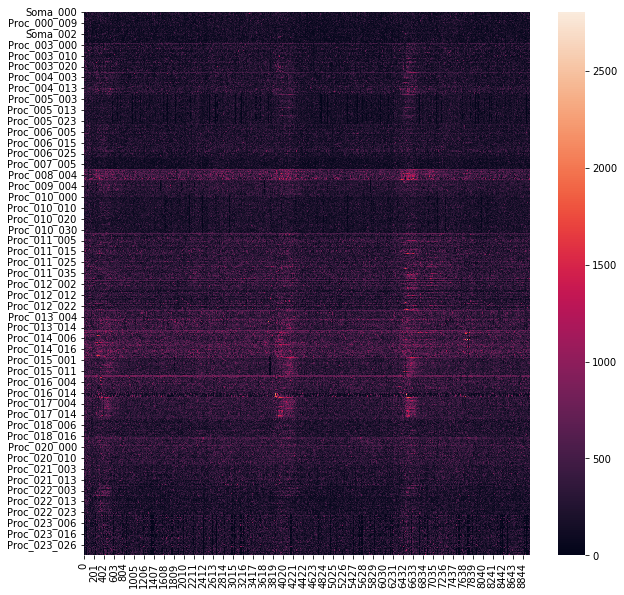

In [34]:
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(B[0].T)

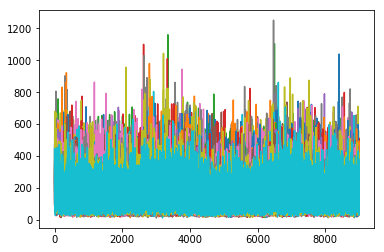

In [45]:
for i in range(20):
    plt.plot(np.arange(9000),B[0].iloc[:,i].values)

In [44]:
B[0].iloc[:,0]

0       175.669118
1       453.389706
2       320.183824
3       157.389706
4       218.323529
5       273.029412
6       138.933824
7       299.242647
8       137.242647
9       215.602941
10      215.926471
11      152.323529
12      257.580882
13      172.154412
14      354.647059
15      184.558824
16      308.036765
17      341.941176
18      427.757353
19      234.477941
20      350.720588
21      133.735294
22      123.860294
23      336.779412
24      293.455882
25      240.419118
26      365.036765
27      232.205882
28      250.654412
29      207.198529
           ...    
8970    453.801471
8971    255.669118
8972    340.823529
8973    249.014706
8974    264.213235
8975    361.500000
8976    173.250000
8977    208.823529
8978    187.985294
8979     97.566176
8980    194.654412
8981    203.610294
8982    365.073529
8983    269.897059
8984    226.286765
8985    332.772059
8986    315.330882
8987    164.183824
8988    279.014706
8989    180.779412
8990    216.235294
8991    224.

In [26]:
single_astro_roi.shape

(24, 512, 512, 2)

In [27]:
image = np.zeros((512,512,3),dtype=np.uint8)

for key in A['ROI_0']:
    
    pt = A['ROI_0'][key]
    
    image[pt[0],pt[1],0] = np.random.randint(1,255,1)[0]
    image[pt[0],pt[1],1] = np.random.randint(1,255,1)[0]
    image[pt[0],pt[1],2] = np.random.randint(1,255,1)[0]


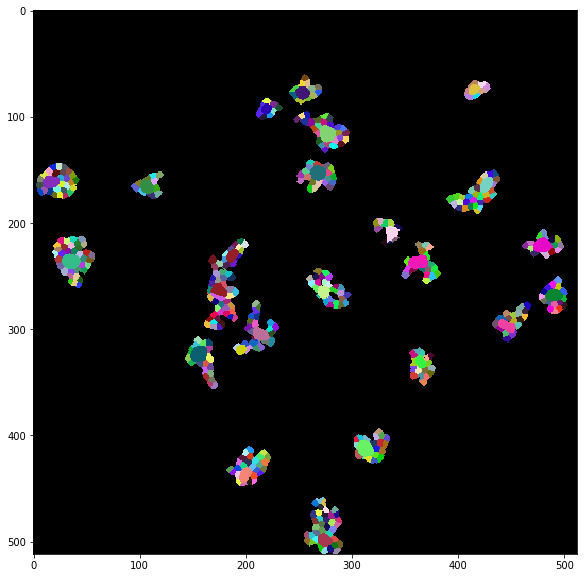

In [28]:
plt.figure(figsize=(10,10))
plt.imshow(image)

In [29]:
np.random.randint(1,255,1)[0]

83